In [1]:
#!/usr/bin python2.7
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pymc3 as pm
import theano
import theano.tensor as T


from astropy.io       import fits
from astropy.table    import Table
from astropy.time     import Time
from datetime         import date
from datetime         import datetime
import ephem
import fileinput
import getpass
import math
import matplotlib.pyplot                   as plt
import matplotlib                          as mpl
import numpy                               as np
from numpy            import linalg        as LA
import os
import pyfits
import scipy.optimize                      as optimization
from scipy            import integrate
from scipy            import interpolate
from scipy.optimize   import curve_fit
import subprocess
from subprocess       import Popen, PIPE
import urllib2
from work_module      import calculate
from work_module      import detector
from work_module      import readfile
from work_module      import writefile
calc = calculate()
det = detector()
rf = readfile()
#wf = writefile()

#docstrings of the different self-made classes within the self-made module
#cdoc = calc.__doc__
#ddoc = det.__doc__
#rdoc = rf.__doc__



day = 150926
detector = det.n5
data_type = 'ctime'
year = int('20' + str(day)[0:2])

#get the iso-date-format from the day
date = datetime(year, int(str(day)[2:4]), int(str(day)[4:6]))

#get the ordinal indicator for the date
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n/10%10!=1)*(n%10<4)*n%10::4])

#read the measurement data
ctime_data = rf.ctime(detector, day)
echan = ctime_data[0]
total_counts = ctime_data[1]
echan_counts = ctime_data[2]
total_rate = ctime_data[3]
echan_rate = ctime_data[4]
bin_time = ctime_data[5]
good_time = ctime_data[6]
exptime = ctime_data[7]
bin_time_mid = np.array((bin_time[:,0]+bin_time[:,1])/2)

echan = 1 #define which energy-channels one wants to look at
counts = echan_rate[echan]
#counts = total_rate

#read the satellite data
sat_data = rf.poshist_bin(day, bin_time_mid, detector, data_type)
sat_time_bin = sat_data[0]
sat_pos_bin = sat_data[1]
sat_lat_bin = sat_data[2]
sat_lon_bin = sat_data[3]
sat_q_bin = sat_data[4]

#calculate the sun data
sun_data = calc.sun_ang_bin(detector, day, bin_time_mid, data_type)
sun_ang_bin = sun_data[0]
sun_ang_bin = calc.ang_eff(sun_ang_bin, echan)[0]

#calculate the earth data
earth_data = calc.earth_ang_bin(detector, day, bin_time_mid, data_type)
earth_ang_bin = earth_data[0]
earth_ang_bin = calc.ang_eff(earth_ang_bin, echan)[0]
#earth_ang_bin = calc.earth_occ_eff(earth_ang_bin, echan)

#read the SFL data
#flares = rf.flares(year)
#flares_day = flares[0]
#flares_time = flares[1]
#if np.any(flares_day == day) == True:
#    flares_today = flares_time[:,np.where(flares_day == day)]
#    flares_today = np.squeeze(flares_today, axis=(1,))/3600.
#else:
#    flares_today = np.array(-5)


#periodical function corresponding to the orbital behaviour -> reference day is 150926, periodical shift per day is approximately 0.199*math.pi
sat_time = rf.poshist(day)[0]
'''def j2000_orb(f, g, counts):#J2000-position oriented orbit
    j2000_orb = f*(calc.intpol(np.sin((2*math.pi*np.arange(len(sat_time)))/5531 + g), day, 0, sat_time, bin_time_mid, detector)[0])
    j2000_orb[np.where(counts == 0)] = 0
    return j2000_orb

def geo_orb(g, h, counts):#LON-oriented orbit (earth rotation considered -> orbit within the magnetic field of the earth)
    geo_orb = g*(calc.intpol(np.sin((2*math.pi*np.arange(len(sat_time)))/6120.85 + h), day, 0, sat_time, bin_time_mid, detector)[0])
    geo_orb[np.where(counts == 0)] = 0
    return geo_orb'''#excluded, because their impact on the background is insignificant


#read the magnetic field data
'''magn_data = rf.magfits(day)
t_magn = magn_data[0]
h_magn = magn_data[1]
x_magn = magn_data[2]
y_magn = magn_data[3]
z_magn = magn_data[4]
t_magn = calc.intpol(t_magn, day, 0, sat_time, bin_time_mid)[0]
h_magn = calc.intpol(h_magn, day, 0, sat_time, bin_time_mid)[0]
z_magn = calc.intpol(z_magn, day, 0, sat_time, bin_time_mid)[0]

magnetic = z_magn#define which component of the magnetic field to plot'''

lat_data = rf.mcilwain(day)
mc_b = lat_data[1]
mc_l = lat_data[2]

mc_b = calc.intpol(mc_b, day, 0, sat_time, bin_time_mid)[0]
mc_l = calc.intpol(mc_l, day, 0, sat_time, bin_time_mid)[0]

magnetic = mc_l
magnetic = magnetic - np.mean(magnetic)

#constant function corresponding to the diffuse y-ray background
cgb = np.ones(len(counts))




In [ ]:
saa_exits = [0]
for i in range(1, len(counts)):
    if np.logical_and(total_rate[i-1] == 0, total_rate[i] != 0):
        print i
        saa_exits.append(i)
saa_exits = np.array(saa_exits)

In [ ]:
def exp_func(x, a, b, i):
    if i == 0:
        addition = 0
    else:
        addition = 5
    x_func = x[saa_exits[i]+addition:] - x[saa_exits[i]+addition]
    func = a*np.exp(-b*x_func)
    zeros = np.zeros(len(x))
    zeros[saa_exits[i]+addition:] = func
    return zeros

In [ ]:
def fit_function(x, a, b, c, d, exp01, exp02, exp11, exp12, exp21, exp22, exp31, exp32, exp41, exp42, exp51, exp52, exp61, exp62, exp71, exp72, exp81, exp82, exp91, exp92):
    zeros = np.zeros(len(x))
    return a*cgb + b*magnetic + c*earth_ang_bin + d*sun_ang_bin + exp_func(x, exp01, exp02, 0) + exp_func(x, exp11, exp12, 1) + exp_func(x, exp21, exp22, 2) + exp_func(x, exp31, exp32, 3) + exp_func(x, exp41, exp42, 4) + exp_func(x, exp51, exp52, 5) + exp_func(x, exp61, exp62, 6) + exp_func(x, exp71, exp72, 7) + exp_func(x, exp81, exp82, 8) + exp_func(x, exp91, exp92, 9)# + j2000_orb(e, f, counts) + geo_orb(g, h, counts)

In [ ]:
zeroCondition = total_rate==0

#counts[120000:] = 0
cgb[np.where(zeroCondition)] = 0
earth_ang_bin[np.where(zeroCondition)] = 0
sun_ang_bin[np.where(zeroCondition)] = 0
magnetic[np.where(zeroCondition)] = 0

In [3]:


zeroCondition = total_rate==0

background_model = pm.Model()

shared_cgb            = theano.shared(cgb[~zeroCondition])
shared_magnetic       = theano.shared(magnetic[~zeroCondition])
shared_earth_ang_bin  = theano.shared(earth_ang_bin[~zeroCondition])
shared_sun_ang_bin    = theano.shared(sun_ang_bin[~zeroCondition])

shared_counts         = theano.shared(counts[~zeroCondition])


shared_bin_time_mid   = theano.shared(bin_time_mid[~zeroCondition])

with background_model:
    
    a_log = pm.Uniform("a_log",lower=log10(10.),upper=log10(200))
    b_log = pm.Uniform("b_log",lower=log10(10.),upper=log10(200))
    
    #a     = pm.Uniform("a",lower=10.,upper=200)
    #b     = pm.Uniform("b",lower=10.,upper=200)
    c     = pm.Uniform("c",lower=-20,upper=20)
    d     = pm.Uniform("d",lower=-20,upper=20)
    
    
    a     = pm.Deterministic('a',T.pow(10.,a_log))
    b     = pm.Deterministic('b',T.pow(10.,b_log))
    
    #combined_curve = pm.Deterministic("combined_curve",a + b*shared_magnetic + c*shared_earth_ang_bin + d*shared_sun_ang_bin )
    likelihood = pm.Poisson("likelihood",mu=a + b*shared_magnetic + c*shared_earth_ang_bin + d*shared_sun_ang_bin,observed=shared_counts)








with background_model:
    start = pm.find_MAP(fmin=optimize.fmin_powell )
    
with background_model:
    
    step = pm.NUTS(scaling=start)   
    
    
n_samples=2500
burn_in = 500

with background_model:
    
    #step = pm.Metropolis()
    
    samples = pm.sample(n_samples,step=step,start=start,progressbar=True)
        

Applied interval-transform to a_log and added transformed a_log_interval to model.
Applied interval-transform to b_log and added transformed b_log_interval to model.
Applied interval-transform to c and added transformed c_interval to model.
Applied interval-transform to d and added transformed d_interval to model.
 [-----------------100%-----------------] 2500 of 2500 complete in 113.1 sec

array([[<matplotlib.axes.AxesSubplot object at 0x7f6063ded550>,
        <matplotlib.axes.AxesSubplot object at 0x7f60687a4710>]], dtype=object)

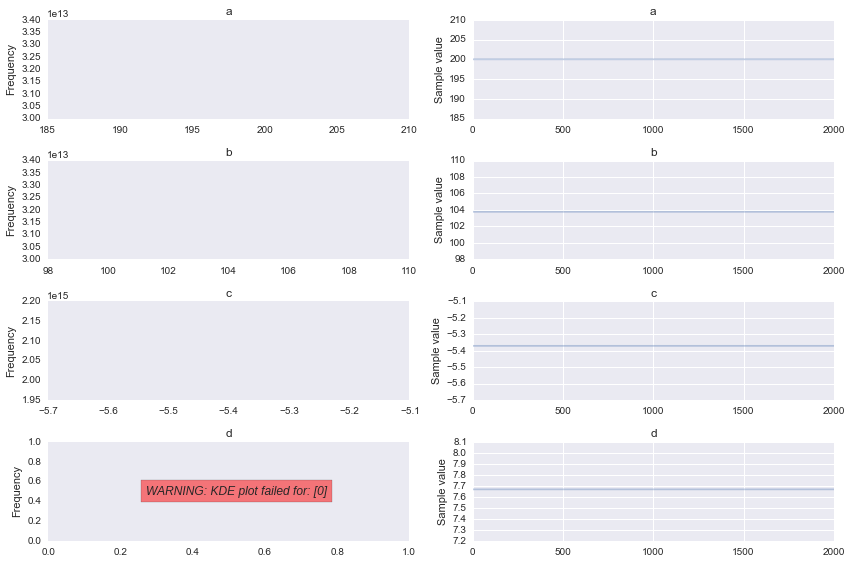

In [4]:
pm.traceplot(samples[burn_in:],varnames=['a','b','c','d'])

In [5]:
pm.summary(samples[burn_in:],varnames=['a','b','c','d'])


a:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  200.000          0.000            0.000            [200.000, 200.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  200.000        200.000        200.000        200.000        200.000


b:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  103.771          0.000            0.000            [103.771, 103.771]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  103.771        103.771        103.771        103.771        103.771


c:

  Mean             SD               MC Error         95% HPD interval
  -------------------------

In [32]:
#dftrace  =pm.trace_to_dataframe(samples[burn_in:],chains=[a,b,c,d])

In [ ]:
x0 = np.array([1300., 20., -12., -1., 40., 0.001, 40., 0.001, 40., 0.001, 40., 0.001, 40., 0.001, 40., 0.001, 40., 0.001, 40., 0.001, 40., 0.001, 40., 0.001])#, 0.5, 0.5, 0.2, -1.3])
sigma = np.array((counts + 1)**(0.5))

fit_results = optimization.curve_fit(fit_function, bin_time_mid, counts, x0, sigma)
coeff = fit_results[0]

In [ ]:
print 'CGB coefficient:',coeff[0]
print 'Magnetic field coefficient:',coeff[1]
print 'Earth angle coefficient:',coeff[2]
print 'Sun angle coefficient:',coeff[3]
print 'starting exp:',coeff[4],'&',coeff[5]
print 'first SAA:',coeff[6],'&',coeff[7]

In [ ]:
a = coeff[0]
b = coeff[1]
c = coeff[2]
d = coeff[3]
exp01 = coeff[4]
exp02 = coeff[5]
exp11 = coeff[6]
exp12 = coeff[7]
exp21 = coeff[8]
exp22 = coeff[9]
exp31 = coeff[10]
exp32 = coeff[11]
exp41 = coeff[12]
exp42 = coeff[13]
exp51 = coeff[14]
exp52 = coeff[15]
exp61 = coeff[16]
exp62 = coeff[17]
exp71 = coeff[18]
exp72 = coeff[19]
exp81 = coeff[20]
exp82 = coeff[21]
exp91 = coeff[22]
exp92 = coeff[23]

fit_curve = a*cgb + b*magnetic + c*earth_ang_bin + d*sun_ang_bin + exp_func(bin_time_mid, exp01, exp02, 0) + exp_func(bin_time_mid, exp11, exp12, 1) + exp_func(bin_time_mid, exp21, exp22, 2) + exp_func(bin_time_mid, exp31, exp32, 3) + exp_func(bin_time_mid, exp41, exp42, 4) + exp_func(bin_time_mid, exp51, exp52, 5) + exp_func(bin_time_mid, exp61, exp62, 6) + exp_func(bin_time_mid, exp71, exp72, 7) + exp_func(bin_time_mid, exp81, exp82, 8) + exp_func(bin_time_mid, exp91, exp92, 9)

In [6]:

#######################
#def fit_function(x, a, b, c, d):
#    return a*cgb + b*magnetic + c*earth_ang_bin + d*sun_ang_bin# + j2000_orb(e, f, counts) + geo_orb(g, h, counts)
#
#x0 = np.array([1300., 20, -12, -1])#, 0.5, 0.5, 0.2, -1.3])
#sigma = np.array((counts + 1)**(0.5))
#
#fit_results = optimization.curve_fit(fit_function, bin_time_mid, counts, x0, sigma)
#
#
######################






CGB coefficient: 364.951095301
Magnetic field coefficient: 3.25856355647
Earth angle coefficient: -7.1673194796
Sun angle coefficient: 1.1955831811


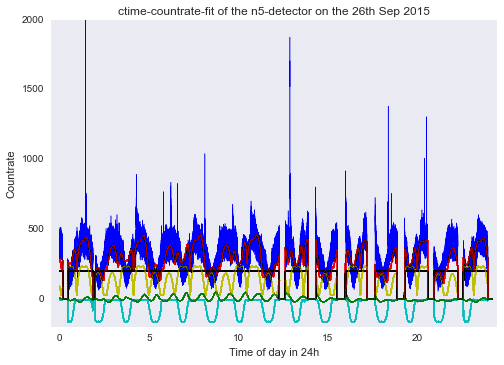

In [7]:
coeff = fit_results[0]

print 'CGB coefficient:',coeff[0]
print 'Magnetic field coefficient:',coeff[1]
print 'Earth angle coefficient:',coeff[2]
print 'Sun angle coefficient:',coeff[3]
'''print 'J2000 orbit coefficient & phase:',coeff[4],'&',coeff[5]
print 'Geographical orbit coefficient & phase:',coeff[6],'&',coeff[7]'''
#print np.where(total_counts == 0)
#print bin_time_mid[np.where(total_counts == 0)]
#print sat_time_bin[np.where(total_counts == 0)]
#print bin_time_mid[0]
#print sat_time_bin[0]

#a = fit_results[0][0]
#b = fit_results[0][1]
#c = fit_results[0][2]
#d = fit_results[0][3]
'''e = fit_results[0][4]
f = fit_results[0][5]
g = fit_results[0][6]
h = fit_results[0][7]

j2000_orb = j2000_orb(e, f, counts)
geo_orb = geo_orb(g, h, counts)'''



#fit_curve = a*cgb + b*magnetic + c*earth_ang_bin + d*sun_ang_bin# + j2000_orb + geo_orb


#plot-algorhythm
plot_time_bin_date = calc.met_to_date(bin_time_mid)[0]
plot_time_bin = (plot_time_bin_date - calc.day_to_met(day)[1])*24#Time of day in hours
plot_time_sat_date = calc.met_to_date(sat_time_bin)[0]
plot_time_sat = (plot_time_sat_date - calc.day_to_met(day)[1])*24#Time of day in hours

#plot each on its own axis (source)
'''fig, ax1 = plt.subplots()

#add two independent y-axes
ax2 = ax1.twinx()
ax3 = ax1.twinx()
#ax4 = ax1.twinx()
axes = [ax1, ax2, ax3]#, ax4]

#Make some space on the right side for the extra y-axis
fig.subplots_adjust(right=0.75)

# Move the last y-axis spine over to the right by 20% of the width of the axes
axes[-1].spines['right'].set_position(('axes', 1.2))

# To make the border of the right-most axis visible, we need to turn the frame on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

plot1 = ax1.plot(plot_time_bin, counts, 'b-', label = 'Counts')
plot2 = ax1.plot(plot_time_bin, fit_curve, 'r-', label = 'Fit')
plot3 = ax2.plot(plot_time_sat, sun_ang_bin, 'y-', label = 'Sun angle')
plot4 = ax2.plot(plot_time_sat, earth_ang_bin, 'c-', label = 'Earth angle')
plot5 = ax3.plot(plot_time_sat, magnetic, 'g-', label = 'Magnetic field')
plot6 = ax3.plot(plot_time_sat, cgb, 'b--', label = 'Cosmic y-ray background')
#plot7 = ax3.plot(plot_time_sat, j2000_orb, 'y--', label = 'J2000 orbit')
#plot8 = ax3.plot(plot_time_sat, geo_orb, 'g--', label = 'Geographical orbit')

plots = plot1 + plot2 + plot3 + plot4 + plot5 + plot6# + plot7 + plot8
labels = [l.get_label() for l in plots]
ax3.legend(plots, labels, loc=1)

ax1.grid()

ax1.set_xlabel('Time of day in 24h')
ax1.set_ylabel('Number of counts')
ax2.set_ylabel('Effective area (cm^2)')
ax3.set_ylabel('Number')
#ax4.set_ylabel('Distance')

#ax1.set_xlim([0, 24.1])
ax1.set_ylim([-50, 100])
#ax2.set_xlim([0, 24.1])
ax2.set_ylim([0, 300])
#ax3.set_xlim([0, 24.1])
ax3.set_ylim([-5.5, 1.5])
#ax4.set_xlim([0, 24.1])
#ax4.set_ylim([-1.5, 1.5])

plt.title(data_type + '-counts-fit of the ' + detector.__name__ + '-detector on the ' + ordinal(int(str(day)[4:6])) + ' ' + date.strftime('%B')[0:3] + ' ' + str(year))

plt.show()'''


#plot each on the same axis as converted to counts
fig, ax1 = plt.subplots()

plot1 = ax1.plot(plot_time_bin, counts, 'b-', lw=.5,label = 'Countrate')

fit_curve_all = []
thin=10

for tr in samples[burn_in::thin]:
    
    fit_curve = tr['a']*cgb + tr['b']*magnetic + tr['c']*earth_ang_bin + tr['d']*sun_ang_bin# + j2000_orb + geo_orb

    plot(plot_time_bin,fit_curve,'r',alpha=.01)
    
    fit_curve = tr['a']*cgb # + j2000_orb + geo_orb

    plot(plot_time_sat,fit_curve,'k',alpha=.01)
    
    
    fit_curve = tr['b']*magnetic # + j2000_orb + geo_orb

    plot(plot_time_sat,fit_curve,'g',alpha=.01)
    
    
    fit_curve = tr['c']*earth_ang_bin # + j2000_orb + geo_orb

    plot(plot_time_sat,fit_curve,'c',alpha=.01)
    
    
    fit_curve = tr['d']*sun_ang_bin # + j2000_orb + geo_orb

    plot(plot_time_sat,fit_curve,'y',alpha=.01)
    

#plot2 = ax1.plot(plot_time_bin, fit_curve, 'r-', label = 'Fit')
#plot3 = ax1.plot(plot_time_sat, d*sun_ang_bin, 'y-', label = 'Sun angle')
#plot4 = ax1.plot(plot_time_sat, c*earth_ang_bin, 'c-', label = 'Earth angle')
#plot5 = ax1.plot(plot_time_sat, b*magnetic, 'g-', label = 'Magnetic field')
#plot6 = ax1.plot(plot_time_sat, a*cgb, 'b--', label = 'Cosmic y-ray background')
#plot7 = ax1.plot(plot_time_sat, j2000_orb, 'y--', label = 'J2000 orbit')
#plot8 = ax1.plot(plot_time_sat, geo_orb, 'g--', label = 'Geographical orbit')

#plot vertical lines for the solar flares of the day
#if np.all(flares_today != -5):
#    if len(flares_today[0]) > 1:
#        for i in range(0, len(flares_today[0])):
#            plt.axvline(x = flares_today[0,i], ymin = 0., ymax = 1., linewidth=2, color = 'grey')
#            plt.axvline(x = flares_today[1,i], ymin = 0., ymax = 1., color = 'grey', linestyle = '--')
#    else:
#        plt.axvline(x = flares_today[0], ymin = 0., ymax = 1., linewidth=2, color = 'grey')
#        plt.axvline(x = flares_today[1], ymin = 0., ymax = 1., color = 'grey', linestyle = '--')

#plots = plot1 + plot2 + plot3 + plot4 + plot5 + plot6# + plot7 + plot8
#labels = [l.get_label() for l in plots]
#ax1.legend(plots, labels, loc=1)

ax1.grid()

ax1.set_xlabel('Time of day in 24h')
ax1.set_ylabel('Countrate')

#ax1.set_xlim([9.84, 9.85])
ax1.set_xlim([-0.5, 24.5])
ax1.set_ylim([-200, 2000])

plt.title(data_type + '-countrate-fit of the ' + detector.__name__ + '-detector on the ' + ordinal(int(str(day)[4:6])) + ' ' + date.strftime('%B')[0:3] + ' ' + str(year))





#plt.plot(plot_time_bin, counts - fit_curve, 'b-')

#plt.xlabel('Time of day in 24h')
#plt.ylabel('Residual noise')

#plt.grid()

#plt.title(data_type + '-counts-fit residuals of the ' + detector.__name__ + '-detector on the ' + ordinal(int(str(day)[4:6])) + ' ' + date.strftime('%B')[0:3] + ' ' + str(year))

#plt.ylim([-200, 200])

#plt.show()
savefig("/home/tkili/Work/plot.pdf",bbox_inches="tight")


In [9]:
dftrace  =pm.trace_to_dataframe(samples[burn_in:])

In [30]:
dftrace

,a,b_log_interval,c,b,d,d_interval,c_interval,b_log,a_log,a_log_interval
0,104.779066,0.258554,0.398691,54.218344,-0.260245,-0.026026,0.039874,1.734146,2.020275,1.290343
1,104.779066,0.258554,0.398691,54.218344,-0.260245,-0.026026,0.039874,1.734146,2.020275,1.290343
2,104.798222,0.260761,0.393511,54.306550,-0.261918,-0.026193,0.039356,1.734852,2.020354,1.290704
3,104.693582,0.258780,0.394220,54.227350,-0.253790,-0.025380,0.039427,1.734218,2.019920,1.288734
4,104.955477,0.256159,0.394919,54.122786,-0.260250,-0.026026,0.039497,1.733380,2.021005,1.293664
5,104.976545,0.255205,0.393414,54.084749,-0.257419,-0.025743,0.039346,1.733075,2.021092,1.294061
6,104.987312,0.253758,0.393963,54.027102,-0.256337,-0.025635,0.039401,1.732612,2.021137,1.294264
7,105.030134,0.254120,0.394337,54.041530,-0.258458,-0.025847,0.039439,1.732728,2.021314,1.295070
8,104.910447,0.256117,0.392289,54.121076,-0.255560,-0.025557,0.039234,1.733366,2.020819,1.292816
9,104.666383,0.262479,0.391822,54.375266,-0.258795,-0.025881,0.039187,1.735401,2.019807,1.288222


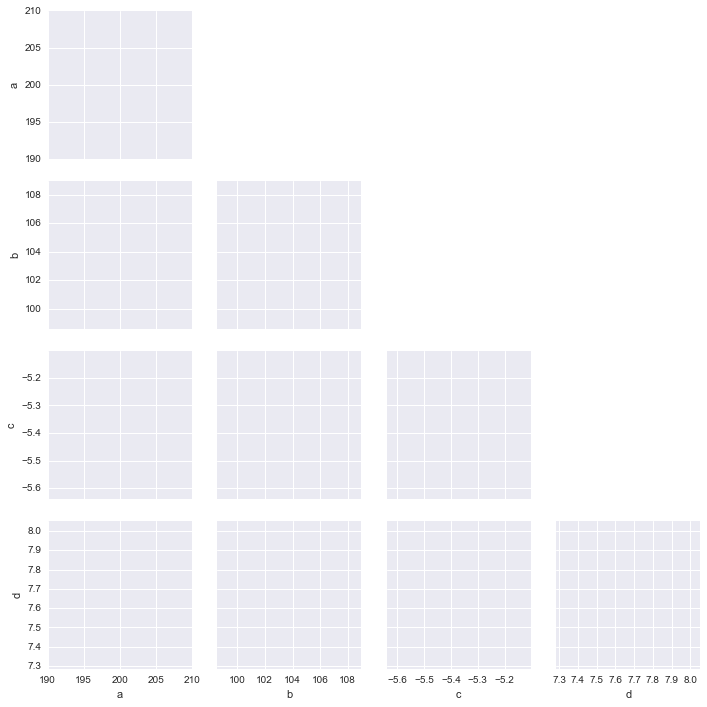

In [10]:
g = sns.PairGrid(dftrace, vars=['a', 'b', 'c', 'd'])
#g = g.map(plt.scatter)
g = g.map(sns.kdeplot, lw=2, n_levels=3, shade=True, cmap="Blues_d", shade_lowest=False)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

In [38]:
g.fig.savefig("/Users/jburgess/Desktop/covaraince_plot.pdf",bbox_inches="tight")

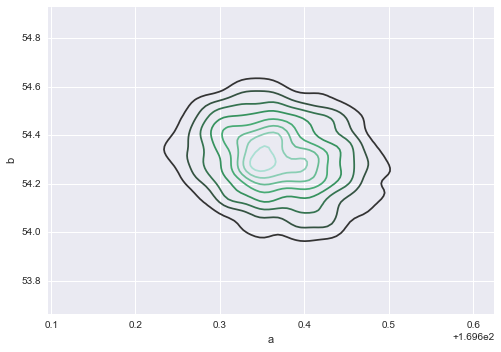

In [10]:
sns.kdeplot(dftrace['a'],dftrace['b'])